In [141]:
#!pip3 install openpyxl
#!pip3 install lxml
#!pip3 install html5lib
#!pip3 install bs4

In [132]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from pmdarima import auto_arima
import warnings

warnings.filterwarnings("ignore")


# Load data
data = pd.read_excel('Interview Dataset.xlsx')

## Data Preprocessing

### Assumptions
1. **Date Parsing and Feature Extraction**:
   - Assumed that the `Year/Month/Day` column is in a standard date format and can be converted directly to a `datetime` object.
   - Extracted `Day_of_Week` and `Month` from the date for time-based features.


2. **Holiday Data**:
   - Assumed that the holiday lists for 2022 and 2023 aquired from Candian calender are  accurate and relevant to the dataset.
   - Concatenated holiday dates from both years into a single series for further analysis.
   

In [133]:
# Parse the date
data['Year/Month/Day'] = pd.to_datetime(data['Year/Month/Day'])

# Extract additional time-based features
data['Day_of_Week'] = data['Year/Month/Day'].dt.dayofweek
data['Month'] = data['Year/Month/Day'].dt.month

# Load the holiday data
holidays_2022 = [
    "2022-01-01", "2022-04-15", "2022-04-18", "2022-05-23", 
    "2022-07-01", "2022-08-01", "2022-09-05", "2022-09-19", 
    "2022-09-30", "2022-10-10", "2022-11-11", "2022-12-25", 
    "2022-12-26"
]
holidays_2023 = [
    "2023-01-01", "2023-04-07", "2023-04-10", "2023-05-22", 
    "2023-07-01", "2023-08-07", "2023-09-04", "2023-09-30", 
    "2023-10-09", "2023-11-11", "2023-12-25", "2023-12-26"
]

# Convert lists to Pandas Series
holidays_2022 = pd.Series(pd.to_datetime(holidays_2022))
holidays_2023 = pd.Series(pd.to_datetime(holidays_2023))

# Concatenate the Series
holidays = pd.concat([holidays_2022, holidays_2023])


In [134]:
data.head()

,Transit Agency,Month Year,Year/Month/Day,Concession,Time of Day,# Boardings,Unnamed: 6,Unnamed: 7,Boardings: # times a customer boards a vehicle,Day_of_Week,Month
0,1,Jan-2022,2022-01-01,00 - Adult,Morning (6AM to 11AM),1742,NaN,NaN,NaN,5,1
1,1,Jan-2022,2022-01-01,00 - Adult,Mid-Day (11AM to 3PM),3719,NaN,NaN,NaN,5,1
2,1,Jan-2022,2022-01-01,00 - Adult,Evening (3PM to 8PM),4387,NaN,NaN,NaN,5,1
3,1,Jan-2022,2022-01-01,00 - Adult,Night (8PM to 6AM),2042,NaN,NaN,NaN,5,1
4,1,Jan-2022,2022-01-01,01 - Child,Morning (6AM to 11AM),7,NaN,NaN,NaN,5,1


3. **Filtering**:
   - **November 2023**: Removed November 2023 data as it was considered out of trend or potentially noisy. This step was taken to improve the model’s performance by ensuring that the data used for training and forecasting is representative and not distorted by anomalies or seasonal effects specific to that month.

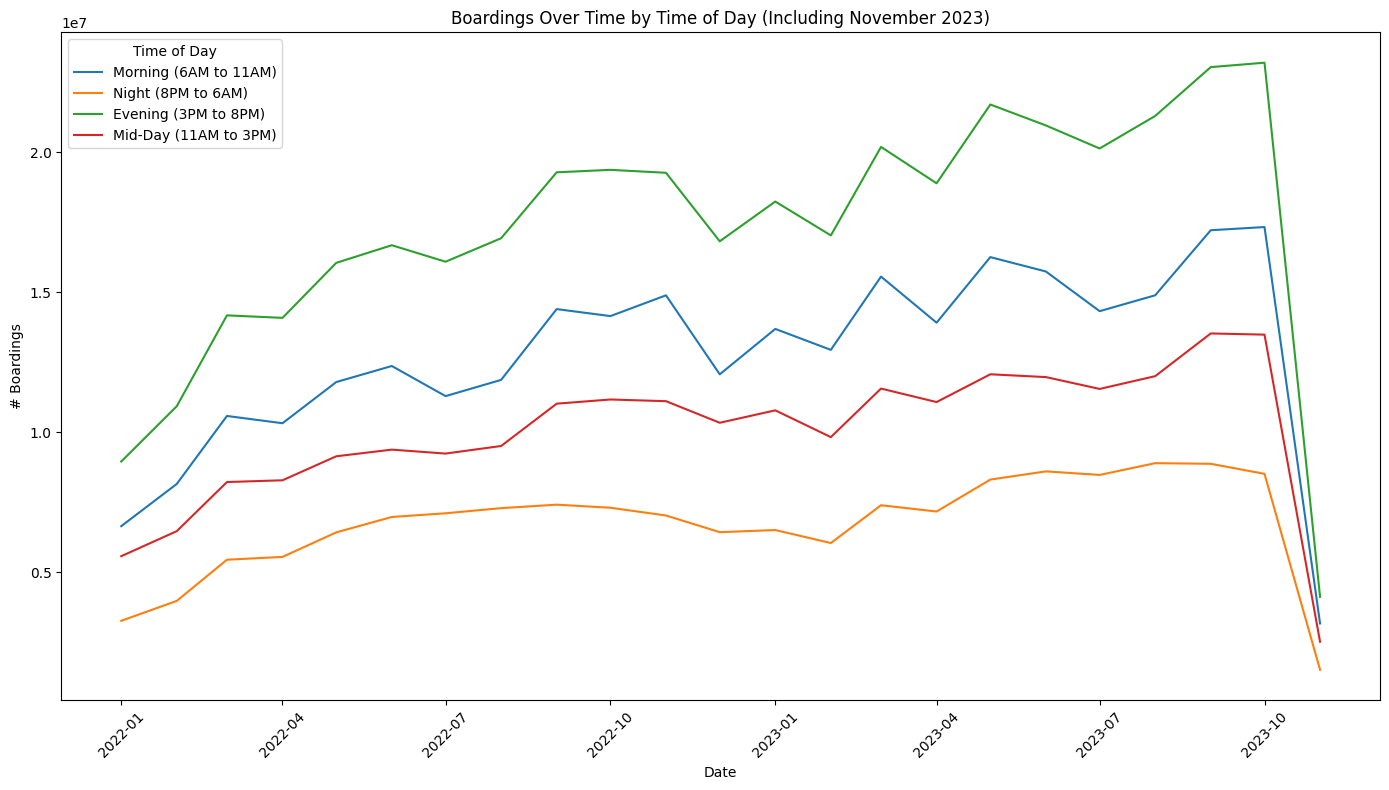

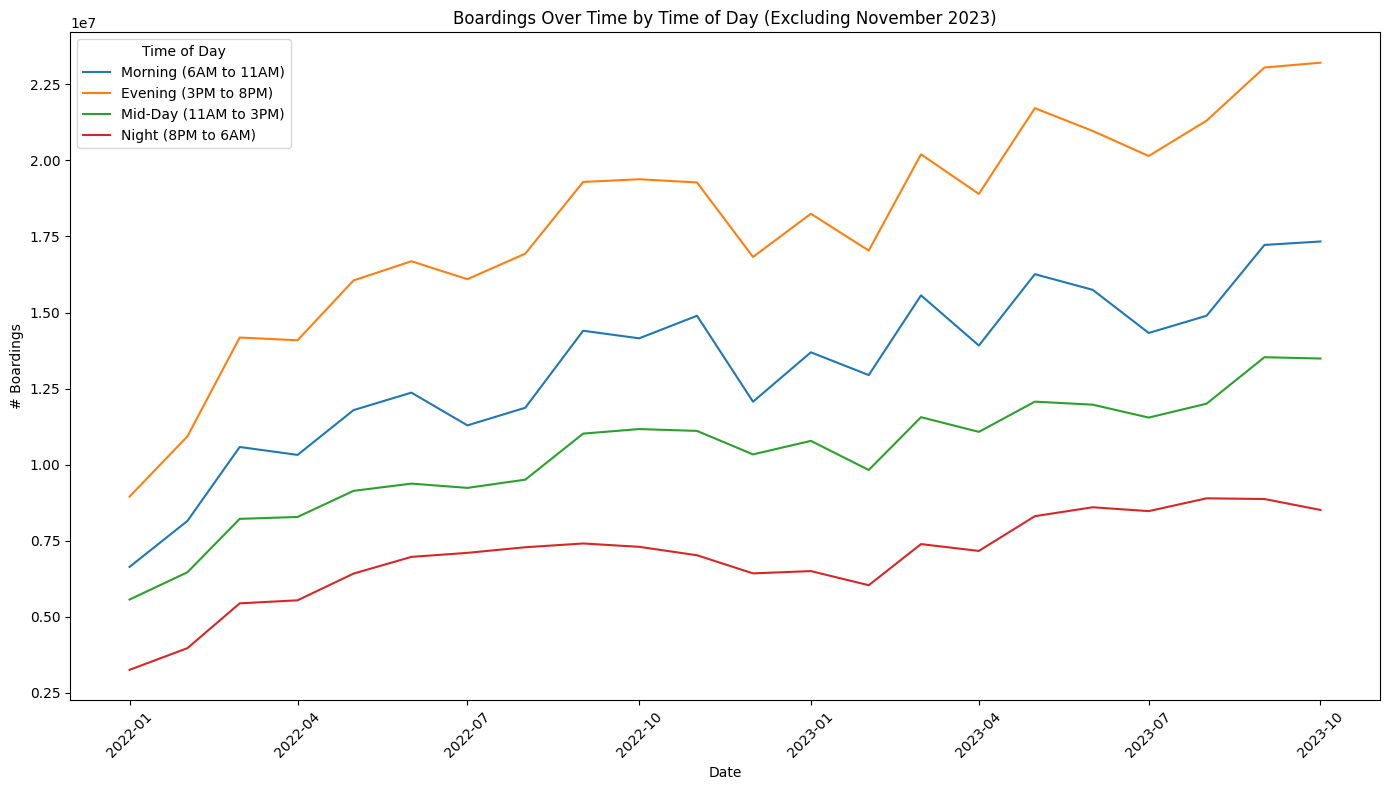

In [135]:
data['Year'] = data['Year/Month/Day'].dt.year
data['Month'] = data['Year/Month/Day'].dt.month

def filter_november_2023(data):
    """
    This function filters out rows corresponding to November 2023
    based on the 'Year/Month/Day' column.
    """
    # Extract year and month
    

    # Filter out November 2023
    filtered_data = data[~((data['Year'] == 2023) & (data['Month'] == 11))]

    return filtered_data

def plot_boardings_over_time(data, title_suffix):
    """
    This function plots the boardings over time grouped by 'Time of Day'.
    """
    plt.figure(figsize=(14, 8))

    # Ensure 'Month' and 'Year' columns are available
    if 'Month' in data.columns and 'Year' in data.columns:
        # Create a datetime column for accurate sorting
        data['Date'] = pd.to_datetime(data[['Year', 'Month']].assign(DAY=1))
        
        # Sort the data by the datetime column
        data = data.sort_values(by='Date')
    else:
        print("Error: 'Month' and 'Year' columns are missing")
        return

    time_of_day_labels = data['Time of Day'].unique()

    for label in time_of_day_labels:
        subset = data[data['Time of Day'] == label]
        grouped = subset.groupby('Date')['# Boardings'].sum()  # Sum or average the boardings as needed
        
        plt.plot(grouped.index, grouped.values, label=label)

    # Customizing the plot
    plt.xlabel('Date')
    plt.ylabel('# Boardings')
    plt.title(f'Boardings Over Time by Time of Day {title_suffix}')
    plt.xticks(rotation=45)
    plt.legend(title='Time of Day')
    plt.tight_layout()

    # Show the plot
    plt.show()

# Plot with the original data (including November 2023)
plot_boardings_over_time(data, "(Including November 2023)")

# Filter out November 2023
filtered_data = filter_november_2023(data)

# Plot with the filtered data (excluding November 2023)
plot_boardings_over_time(filtered_data, "(Excluding November 2023)")


## Aggregation and Train-Test Split

### Aggregation
1. **Daily Aggregation**:
   - Aggregated boardings at a daily level by summing boardings for each `Time of Day` to provide a clearer picture of daily trends and facilitate more accurate forecasting.
  



In [136]:
# Aggregate the filtered data at a daily level and apply EMA smoothing
daily_filtered_data = filtered_data.groupby(['Year/Month/Day', 'Time of Day'])['# Boardings'].sum().reset_index()
daily_filtered_data.rename(columns={'Year/Month/Day': 'Date'}, inplace=True)
daily_filtered_data.set_index('Date', inplace=True)

daily_filtered_data.head()

,Time of Day,# Boardings
Date,,
2022-01-01,Evening (3PM to 8PM),125811
2022-01-01,Mid-Day (11AM to 3PM),87893
2022-01-01,Morning (6AM to 11AM),54209
2022-01-01,Night (8PM to 6AM),58567
2022-01-02,Evening (3PM to 8PM),181341


In [137]:
daily_filtered_data['# Boardings (EMA)'] = round(daily_filtered_data.groupby('Time of Day')['# Boardings'].transform(lambda x: x.ewm(span=7, adjust=False).mean()))

In [138]:
daily_filtered_data.head()

,Time of Day,# Boardings,# Boardings (EMA)
Date,,,
2022-01-01,Evening (3PM to 8PM),125811,125811.0
2022-01-01,Mid-Day (11AM to 3PM),87893,87893.0
2022-01-01,Morning (6AM to 11AM),54209,54209.0
2022-01-01,Night (8PM to 6AM),58567,58567.0
2022-01-02,Evening (3PM to 8PM),181341,139694.0


 - Applied Exponential Moving Average (EMA) smoothing to the aggregated data to reduce noise and highlight trends.
 ### Assumptions
1. **Plotting**:
   - Assumed that plotting boardings over time by a  single `Time of Day` for evening slot  provides meaningful insights into trends and patterns.
   - Used moving averages (EMA) for smoothing to better visualize trends and reduce noise.

<Axes: xlabel='Date'>

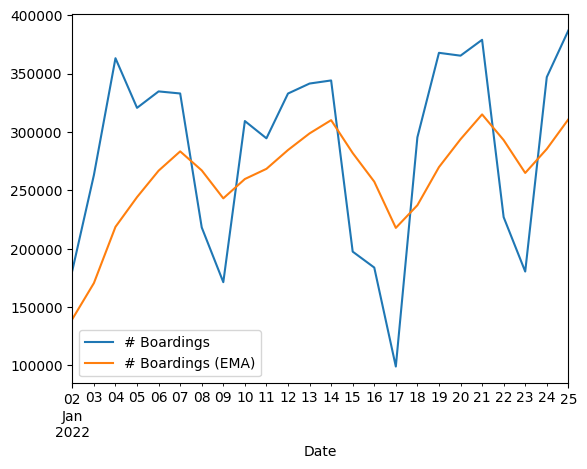

In [139]:
daily_filtered_data.loc[daily_filtered_data['Time of Day']=='Evening (3PM to 8PM)',['# Boardings','# Boardings (EMA)']][1:25].plot()

### Train-Test Split
1. **Splitting**:
   - Split the data into training and test sets based on a date threshold of `September 1, 2023`. Data before this date was used for training, and data from `September 1, 2023`, onwards was used for testing.
   - This split ensures that the models are trained on historical data and tested on future data to evaluate their forecasting performance.


In [142]:
# Prepare data
train_data = daily_filtered_data.loc[daily_filtered_data.index < '2023-09-01']
test_data = daily_filtered_data.loc[daily_filtered_data.index >= '2023-09-01']


## Feature Engineering

### Assumptions
1. **Creating Additional Features**:
   - Assumed that `Day_of_Week`, `Month`, and `Year` are relevant features for modeling time series data in this context.
   - Used these features to capture temporal patterns and trends in boardings.


In [143]:
def create_features(df):
    df['Day_of_Week'] = df.index.dayofweek
    df['Month'] = df.index.month
    df['Year'] = df.index.year
    return df


## Forecasting Models

### Random Forest

1. **Model Assumptions**:
   - Assumed that Random Forest Regressor, with 100 estimators, is suitable for predicting boardings based on time-based features.
   - Used `Day_of_Week`, `Month`, and `Year` as features for training and prediction.

2. **Forecasting**:
   - Forecasted daily boardings for September 2023 using the trained Random Forest model.

3. **Performance Measurement**:
   - Used Mean Absolute Percentage Error (MAPE) to evaluate model performance. Lower MAPE values indicate better model accuracy.


In [144]:

def random_forest_forecast(train_data, test_data):
    results = {}
    mape_scores = {}

    for time_of_day in train_data['Time of Day'].unique():
        train_subset = train_data[train_data['Time of Day'] == time_of_day]
        test_subset = test_data[test_data['Time of Day'] == time_of_day]
        
        X_train = train_subset[['Day_of_Week', 'Month', 'Year']]
        y_train = train_subset['# Boardings (EMA)']
        X_test = test_subset[['Day_of_Week', 'Month', 'Year']]
        y_test = test_subset['# Boardings (EMA)']

        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)

        forecast_dates = pd.date_range(start='2023-09-01', end='2023-09-30')
        future_features = pd.DataFrame({
            'Date': forecast_dates,
            'Day_of_Week': forecast_dates.dayofweek,
            'Month': forecast_dates.month,
            'Year': forecast_dates.year,
            'Time of Day': time_of_day
        })
        
        future_features.set_index('Date', inplace=True)
        X_future = future_features[['Day_of_Week', 'Month', 'Year']]
        
        forecast = model.predict(X_future)
        results[time_of_day] = pd.Series(forecast, index=forecast_dates)

        predictions = model.predict(X_test)
        mape = mean_absolute_percentage_error(y_test, predictions)
        mape_scores[time_of_day] = mape

    return results, mape_scores



### ARIMA (SARIMAX)

1. **Stationarity**:
   - Performed the Dickey-Fuller test to check for stationarity. Assumed that a stationary series is required for ARIMA models.

2. **Optimal Parameters**:
   - Used `auto_arima` to determine optimal SARIMA parameters for modeling. Assumed that seasonal effects are captured by the SARIMA model with seasonal parameters.

3. **Model Fitting**:
   - Fitted SARIMAX models using the identified optimal parameters. Forecasted for the next 30 days and compared predictions with actual values.

4. **Performance Measurement**:
   - Evaluated model performance using MAPE to gauge accuracy.

In [145]:

def perform_dickey_fuller_test(time_series):
    result = adfuller(time_series)
    print('ADF Statistic:', result[0])
    print('p-value:', result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print(f'\t{key}: {value}')
    
    if result[1] <= 0.05:
        print("The time series is stationary")
    else:
        print("The time series is not stationary")

def find_optimal_params(time_series):
    model = auto_arima(time_series, seasonal=True, m=7,
                       start_p=0, start_q=0, max_p=5, max_q=5, max_d=2,
                       start_P=0, start_Q=0, max_P=5, max_Q=5, max_D=2,
                       trace=True, error_action='ignore', suppress_warnings=True, stepwise=True)
    
    print(f"Optimal SARIMA parameters: {model.order}+{model.seasonal_order}")
    return model.order, model.seasonal_order

def arima_forecast(train_data, test_data):
    results = {}
    mape_scores = {}

    for time_of_day in train_data['Time of Day'].unique():
        train_subset = train_data[train_data['Time of Day'] == time_of_day]
        test_subset = test_data[test_data['Time of Day'] == time_of_day]
        
        print(f"\nAnalyzing Time of Day: {time_of_day}")
        
        # Perform Dickey-Fuller test
        print("\nDickey-Fuller Test Results:")
        perform_dickey_fuller_test(train_subset['# Boardings (EMA)'])
        
        # Find optimal parameters
        print("\nFinding optimal SARIMA parameters...")
        order, seasonal_order = find_optimal_params(train_subset['# Boardings (EMA)'])
        
        # Fit SARIMAX model with optimal parameters
        model = SARIMAX(train_subset['# Boardings (EMA)'], order=order, seasonal_order=seasonal_order)
        results_arima = model.fit(disp=False)

        forecast = results_arima.forecast(steps=30)
        results[time_of_day] = forecast

        predictions = results_arima.forecast(steps=len(test_subset))
        mape = mean_absolute_percentage_error(test_subset['# Boardings (EMA)'], predictions)
        mape_scores[time_of_day] = mape

    return results, mape_scores


# Forecasting Model Evaluation

## Visualization of Forecast vs. Real Data

The following function, `plot_forecast_vs_real`, is used to visualize the forecasted versus real boardings data. It generates plots for each `Time of Day`, comparing the predictions from the forecasting models with the actual boardings data.


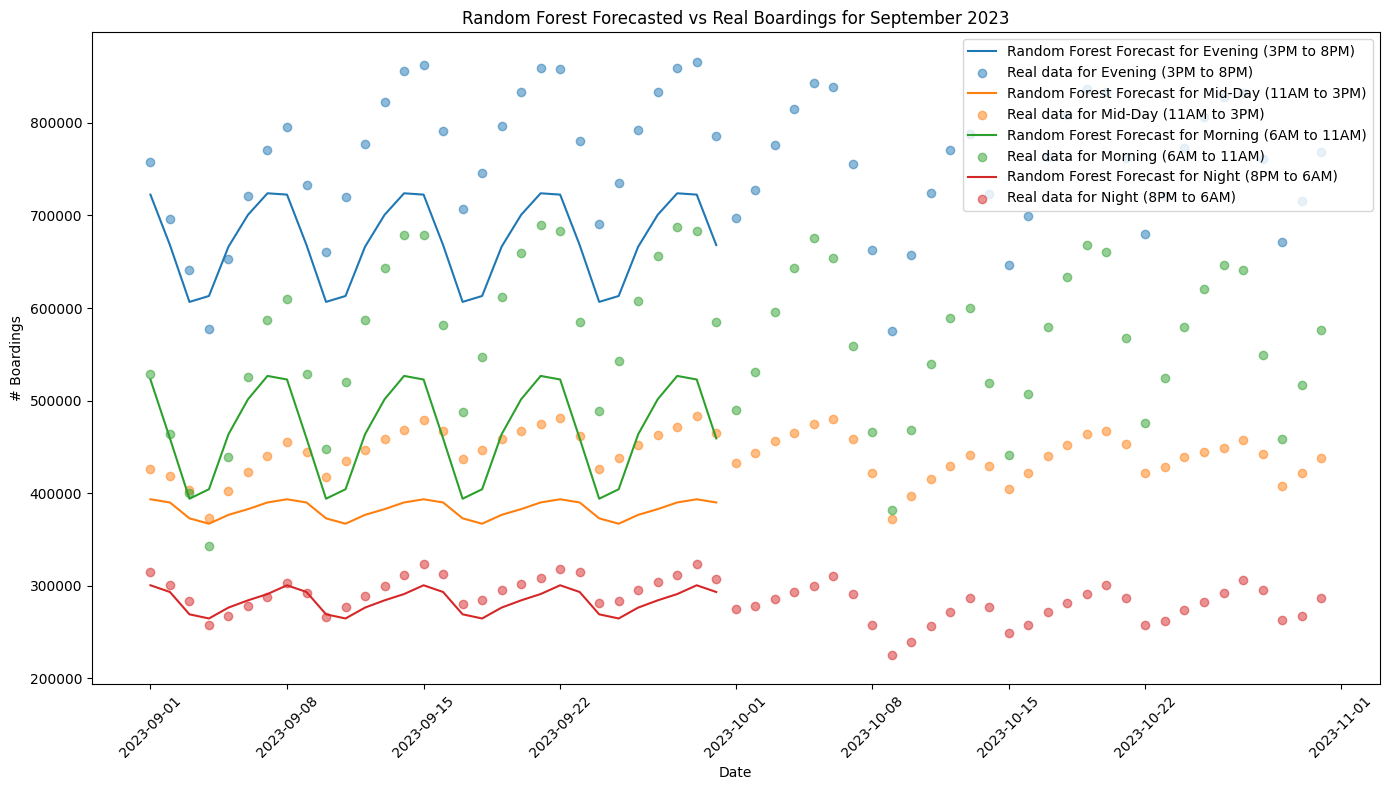

Random Forest MAPE scores:
MAPE for Evening (3PM to 8PM): 0.12
MAPE for Mid-Day (11AM to 3PM): 0.13
MAPE for Morning (6AM to 11AM): 0.18
MAPE for Night (8PM to 6AM): 0.04

Analyzing Time of Day: Evening (3PM to 8PM)

Dickey-Fuller Test Results:
ADF Statistic: -3.1704842231770862
p-value: 0.02175800827782778
Critical Values:
	1%: -3.44152019959894
	5%: -2.8664679191981297
	10%: -2.569394451038919
The time series is stationary

Finding optimal SARIMA parameters...
Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[7] intercept   : AIC=14608.782, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[7] intercept   : AIC=14127.315, Time=0.47 sec
 ARIMA(0,1,1)(0,0,1)[7] intercept   : AIC=14271.754, Time=0.17 sec
 ARIMA(0,1,0)(0,0,0)[7]             : AIC=14607.186, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[7] intercept   : AIC=14506.582, Time=0.05 sec
 ARIMA(1,1,0)(2,0,0)[7] intercept   : AIC=14094.683, Time=0.42 sec
 ARIMA(1,1,0)(3,0,0)[7] intercept   : AIC=inf, Time=1.04 sec
 ARIMA(1,1,0)(2,0,1)[7] int

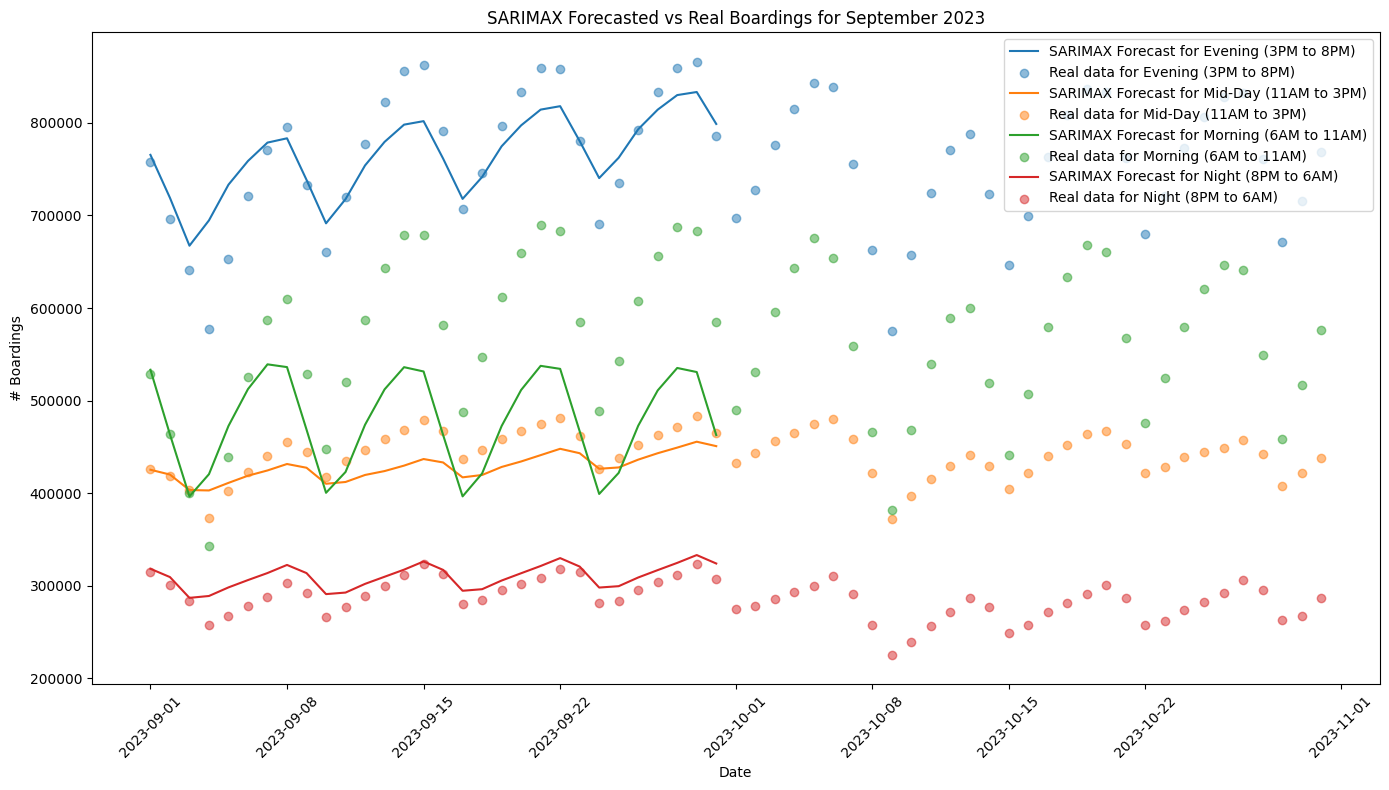


SARIMAX MAPE scores:
MAPE for Evening (3PM to 8PM): 0.08
MAPE for Mid-Day (11AM to 3PM): 0.05
MAPE for Morning (6AM to 11AM): 0.16
MAPE for Night (8PM to 6AM): 0.11


In [131]:

def plot_forecast_vs_real(results, test_data, model_name):
    plt.figure(figsize=(14, 8))
    for time_of_day, forecast_series in results.items():
        # Plot forecast
        plt.plot(forecast_series.index, forecast_series.values, label=f'{model_name} Forecast for {time_of_day}')
        
        # Plot real data
        real_data = test_data[test_data['Time of Day'] == time_of_day]
        plt.scatter(real_data.index, real_data['# Boardings (EMA)'], 
                    label=f'Real data for {time_of_day}', alpha=0.5)

    plt.xlabel('Date')
    plt.ylabel('# Boardings')
    plt.title(f'{model_name} Forecasted vs Real Boardings for September 2023')
    plt.xticks(rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()


train_data = create_features(train_data)
test_data = create_features(test_data)

# Random Forest Model
rf_results, rf_mape_scores = random_forest_forecast(train_data, test_data)
plot_forecast_vs_real(rf_results, test_data, "Random Forest")

print("Random Forest MAPE scores:")
for time_of_day, mape in rf_mape_scores.items():
    print(f"MAPE for {time_of_day}: {mape:.2f}")

# ARIMA Model
arima_results, arima_mape_scores = arima_forecast(train_data, test_data)
plot_forecast_vs_real(arima_results, test_data, "SARIMAX")

print("\nSARIMAX MAPE scores:")
for time_of_day, mape in arima_mape_scores.items():
    print(f"MAPE for {time_of_day}: {mape:.2f}")

# Forecasting Model Evaluation Results

## Random Forest Model

The Random Forest model was evaluated for forecasting boardings for each `Time of Day`. The Mean Absolute Percentage Error (MAPE) scores are as follows:

- **Evening (3PM to 8PM)**: 0.12
- **Mid-Day (11AM to 3PM)**: 0.13
- **Morning (6AM to 11AM)**: 0.18
- **Night (8PM to 6AM)**: 0.04

## SARIMAX Model

The SARIMAX model was analyzed for each `Time of Day` with the following results:

- **Dickey-Fuller Test for Evening (3PM to 8PM)**:
  - ADF Statistic: -3.17
  - p-value: 0.022
  - Critical Values:
    - 1%: -3.44
    - 5%: -2.87
    - 10%: -2.57
  - The time series is stationary.

- **Optimal SARIMA Parameters for Evening (3PM to 8PM)**:
  - Model: ARIMA(1,1,0)(4,0,1)[7]
  - AIC: 14094.683
  - Total fit time: 157.739 seconds

- **SARIMAX MAPE Scores**:
  - **Evening (3PM to 8PM)**: 0.08
  - **Mid-Day (11AM to 3PM)**: 0.05
  - **Morning (6AM to 11AM)**: 0.16
  - **Night (8PM to 6AM)**: 0.11

## Summary

- The Random Forest model showed varying performance across different times of day, with the Night time period achieving the lowest MAPE, indicating the best accuracy.
- The SARIMAX model generally performed better with lower MAPE scores compared to the Random Forest model, especially for Mid-Day and Evening periods.

## Potential Improvements

1. **Feature Engineering**:
   - Additional features such as weather conditions or special events might enhance model performance.
   
2. **Hyperparameter Tuning**:
   - Further tuning of model parameters could potentially improve forecasting accuracy.

3. **Model Evaluation**:
   - Implementing cross-validation and exploring other time series models could provide more robust insights.

4. **Error Analysis**:
   - Analyzing prediction errors in detail might uncover patterns or areas for improvement in the forecasting models.

5. **Seasonality Analysis**:
   - Exploring different seasonalities or applying additional seasonal adjustments could refine the forecasts.

These steps could help in further enhancing the forecasting accuracy and providing deeper insights into the boarding patterns.
